In [1]:

import pandas as pd
df = pd.read_pickle('../Data/combined_train.pkl')

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os


# Data preparation
X_np = df[['lat_norm', 'lon_sin', 'lon_cos', 'SSS', 'SST', 'mon_cos', 'mon_sin', 'Z']].values
y_np = df['c'].values


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

# Initialize KFold
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

fold_metrics = []
all_histories = []

def create_model(input_shape):
    model = keras.Sequential()

    # First dense layer with 320 units, ReLU activation, and Batch Normalization
    model.add(layers.Dense(320, activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())


    # Second dense layer with 160 units, ReLU activation, and Batch Normalization
    model.add(layers.Dense(160, activation='relu'))
    model.add(layers.BatchNormalization())


    # Third dense layer with 160 units, ReLU activation, and Batch Normalization
    model.add(layers.Dense(160, activation='relu'))
    model.add(layers.BatchNormalization())


    # Fourth dense layer with 80 units, ReLU activation, and Batch Normalization
    model.add(layers.Dense(80, activation='relu'))
    model.add(layers.BatchNormalization())


    # Fifth dense layer with 40 units, ReLU activation, and Batch Normalization
    model.add(layers.Dense(40, activation='relu'))
    model.add(layers.BatchNormalization())


    # Output layer with linear activation
    model.add(layers.Dense(1, activation='linear'))
    
    # Compile the model with Adam optimizer and a learning rate of 0.0012
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0012),
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model



In [4]:
# Custom callback to print a dot for each epoch, if needed
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
# Perform cross-validation
for fold_num, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'Fold {fold_num + 1}/{n_folds}')
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    scaler = StandardScaler()
    X_train_fold_standardized = scaler.fit_transform(X_train_fold)
    X_val_fold_standardized = scaler.transform(X_val_fold)

    model = create_model((X_train_fold_standardized.shape[1],))
    
    # Early stopping callback
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,min_delta=0.1)

    # Training the model with verbose logging
    history = model.fit(X_train_fold_standardized, y_train_fold, epochs=20,
                        validation_data=(X_val_fold_standardized, y_val_fold),
                        batch_size=65536,
                        callbacks=[early_stop, PrintDot()],
                        verbose=1)  # Set verbose to 1 to see the training progress
    
    all_histories.append(history.history)

    # Evaluate and print the model performance for the current fold
    fold_score = model.evaluate(X_val_fold_standardized, y_val_fold, verbose=0)
    fold_metrics.append(fold_score)
    print(f'\nFold {fold_num + 1} MAE: {fold_score[1]} MSE: {fold_score[2]}')



Fold 1/5
Epoch 1/20
721/721 [==============================] - 354s 484ms/step - loss: 1468.4080 - mean_absolute_error: 1468.4080 - mean_squared_error: 2157319.0000 - val_loss: 1409.7295 - val_mean_absolute_error: 1409.7295 - val_mean_squared_error: 1987946.2500

.Epoch 2/20
721/721 [==============================] - 354s 491ms/step - loss: 1319.3964 - mean_absolute_error: 1319.3964 - mean_squared_error: 1745307.3750 - val_loss: 1201.3569 - val_mean_absolute_error: 1201.3569 - val_mean_squared_error: 1444006.8750
.Epoch 3/20
721/721 [==============================] - 358s 497ms/step - loss: 1048.4790 - mean_absolute_error: 1048.4790 - mean_squared_error: 1108820.2500 - val_loss: 876.1600 - val_mean_absolute_error: 876.1600 - val_mean_squared_error: 768652.7500
.Epoch 4/20
721/721 [==============================] - 368s 510ms/step - loss: 677.8907 - mean_absolute_error: 677.8907 - mean_squared_error: 474806.9062 - val_loss: 459.7490 - val_mean_absolute_error: 459.7490 - val_mean_squared

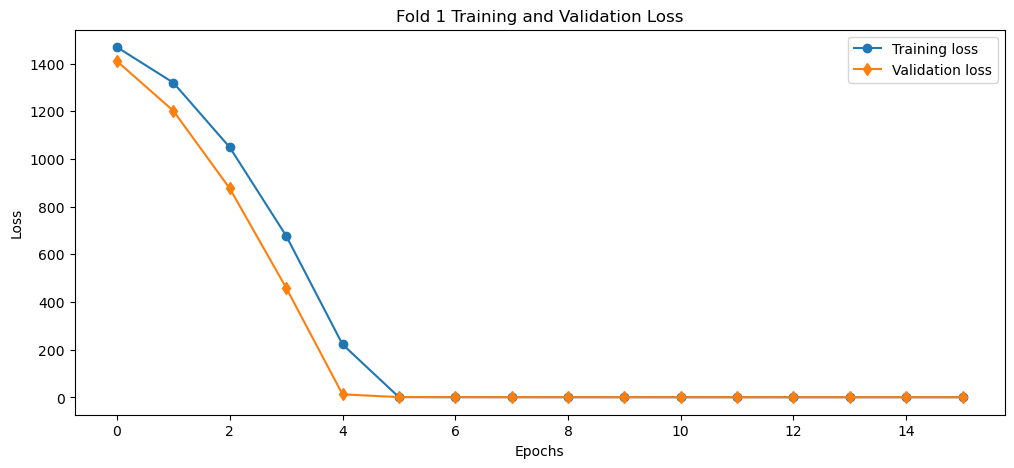

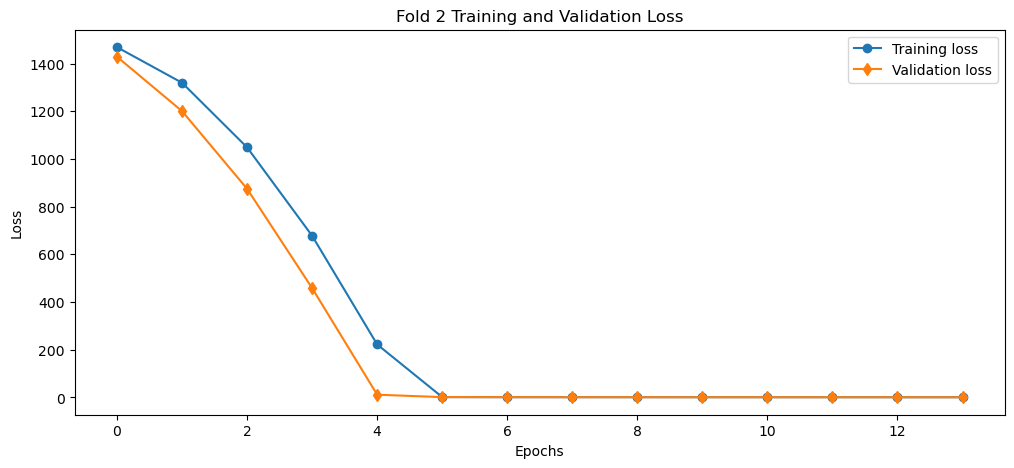

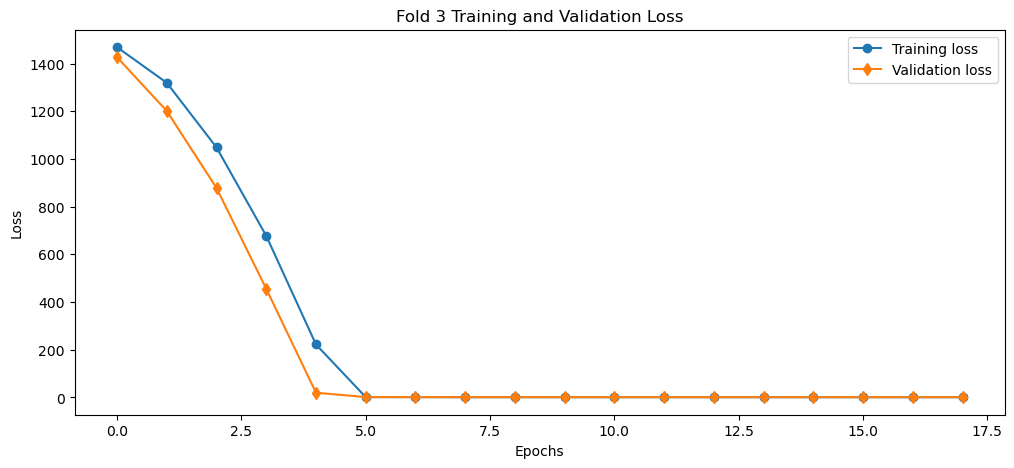

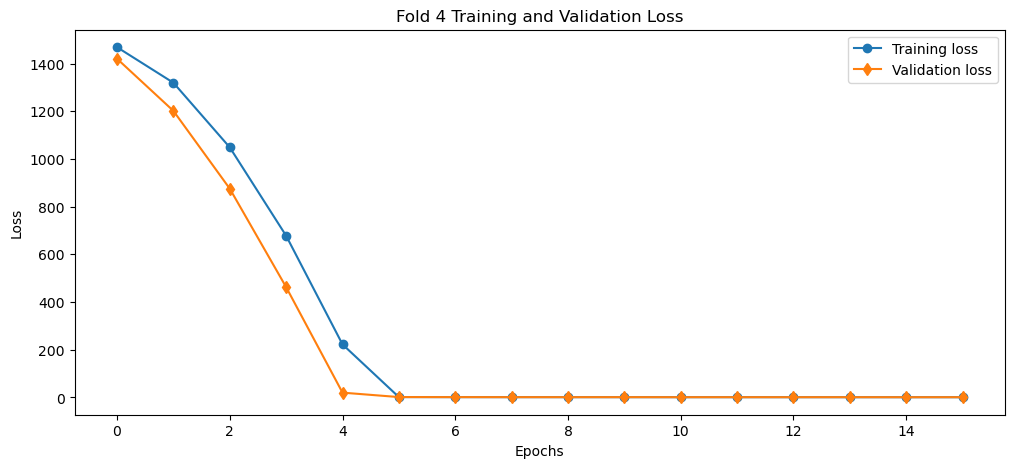

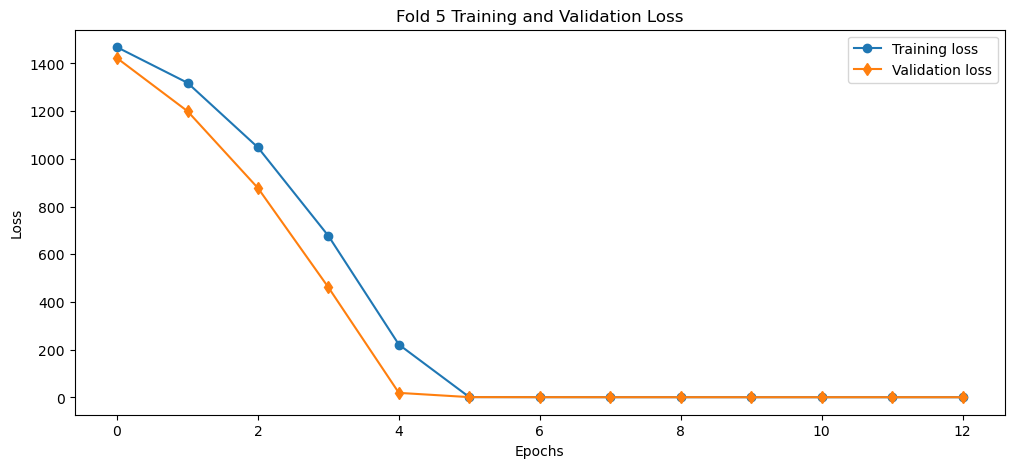

c:\Users\MachineLearning\Anaconda3\envs\ML23Jan\lib\site-packages\numpy\core\_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


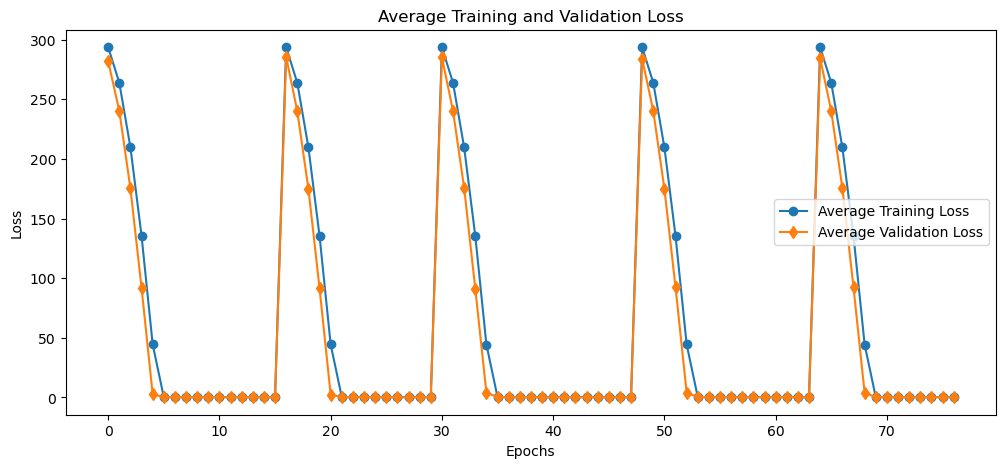

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curves(all_histories):
    n_folds = len(all_histories)

    # Plotting learning curves for each fold
    for i, history in enumerate(all_histories):
        plt.figure(figsize=(12, 5))

        # Plot training and validation loss
        plt.plot(history['loss'], 'o-', label='Training loss')
        plt.plot(history['val_loss'], 'd-', label='Validation loss')
        plt.title(f'Fold {i+1} Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    # Aggregated plot
    avg_training_loss = np.mean([h['loss'] for h in all_histories], axis=0)
    avg_validation_loss = np.mean([h['val_loss'] for h in all_histories], axis=0)

    plt.figure(figsize=(12, 5))

    # Plot average training and validation loss
    plt.plot(avg_training_loss, 'o-', label='Average Training Loss')
    plt.plot(avg_validation_loss, 'd-', label='Average Validation Loss')
    plt.title('Average Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming 'all_histories' is a list of dictionaries containing history data from each fold
plot_learning_curves(all_histories)


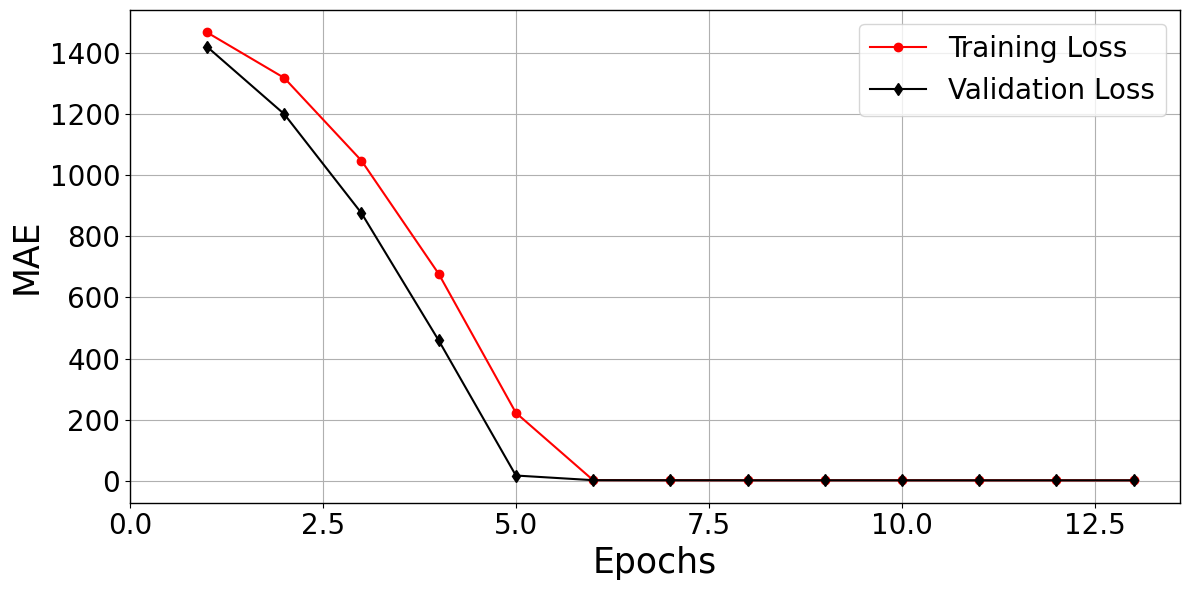

In [57]:
import matplotlib.pyplot as plt

# Find the minimum number of epochs completed by all folds
min_epochs = min(len(history['val_loss']) for history in all_histories)

# Prepare data structures for storing averaged metrics
average_train_loss = [0] * min_epochs
average_val_loss = [0] * min_epochs

# Aggregate the metrics
for history in all_histories:
    for i in range(min_epochs):
        average_train_loss[i] += history['loss'][i]
        average_val_loss[i] += history['val_loss'][i]

# Average the metrics
average_train_loss = [x / len(all_histories) for x in average_train_loss]
average_val_loss = [x / len(all_histories) for x in average_val_loss]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(1, min_epochs + 1), average_train_loss, 'o-', color="r", label='Training Loss')
plt.plot(range(1, min_epochs + 1), average_val_loss,'d-', color="k", label='Validation Loss')
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('MAE', fontsize=25)
plt.legend(loc="best",fontsize=20)
plt.xticks(np.arange(0,15, 2.5), fontsize=20)
plt.yticks(np.arange(0,1600, 200), fontsize=20)
plt.grid()
plt.savefig(r'D:\Nik\Paper1\PaperPlot\lc_com_dnn.png', dpi=300, bbox_inches='tight')
plt.show()



In [7]:
# Evaluate the model on the test set after cross-validation
X_test_standardized = scaler.transform(X_test)
test_score = model.evaluate(X_test_standardized, y_test, verbose=0)
print(f'\nTest set MAE: {test_score[1]} MSE: {test_score[2]}')


Test set MAE: 0.9352564215660095 MSE: 2.9911818504333496


In [8]:
predictions = model.predict(X_test_standardized,batch_size=2048)

In [9]:
columns = ['lat_norm', 'lon_sin', 'lon_cos', 'SSS', 'SST', 'mon_cos', 'mon_sin', 'z']
y_test_df = pd.DataFrame(y_test, columns=['c'])

plot_df = pd.DataFrame(X_test, columns=columns)
plot_df 



,lat_norm,lon_sin,lon_cos,SSS,SST,mon_cos,mon_sin,z
0,-0.613889,-0.398749,-0.917060,34.095707,8.324384,5.000000e-01,8.660254e-01,-1007.155029
1,0.656408,-0.919181,0.393836,34.699200,9.199600,-1.836970e-16,-1.000000e+00,-921.213308
2,-0.269444,0.636078,-0.771625,36.532185,25.239351,8.660254e-01,5.000000e-01,-257.470001
3,0.024094,-0.944911,0.327327,35.889000,27.191000,6.123234e-17,1.000000e+00,-2807.420881
4,-0.322278,0.857018,0.515286,35.563800,19.142800,-5.000000e-01,-8.660254e-01,-2480.269055
...,...,...,...,...,...,...,...,...
14757322,-0.474067,0.865856,0.500293,34.301100,12.472800,6.123234e-17,1.000000e+00,-3995.656188
14757323,-0.310556,-0.998657,-0.051813,36.769100,25.233700,1.000000e+00,-2.449294e-16,-222.390732
14757324,0.463889,-0.923880,0.382683,35.750885,17.241873,1.000000e+00,-2.449294e-16,-1765.135010
14757325,-0.161111,0.173676,0.984803,36.413600,26.394600,6.123234e-17,1.000000e+00,-629.345222


In [10]:
plot_df['c'] = y_test_df['c']
plot_df['pred'] = predictions.flatten()

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score


def calculate_metrics(x, y):
    # 1. RMSE
    rmse = np.sqrt(mean_squared_error(x, y))

    # 2. R^2
    r2 = r2_score(x, y)

    # 3. Pearson correlation coefficient (r) and 95% confidence interval
    r, _ = stats.pearsonr(x, y)
    
    # Compute the confidence interval for Pearson correlation coefficient
    conf_coeff = 1.96 * np.sqrt((1 - r**2) / (len(x) - 2))
    conf_interval = (r - conf_coeff, r + conf_coeff)
    
    # 4. Spearman's correlation coefficient
    spearman_corr, _ = stats.spearmanr(x, y)
    
    return rmse, r2, r, conf_interval, spearman_corr

def plot_scatter(df, x_column, y_column, file_name):
    """
    Plot and save a scatter plot with the given dataframe and specified columns.
    
    Parameters:
    - df: pandas DataFrame containing the data to plot.
    - x_column: string, name of the column to use for the x-axis.
    - y_column: string, name of the column to use for the y-axis.
    - file_name: string, the name of the file to save the plot to.
    """
    # Set the figure size and layout
    plt.rcParams["figure.figsize"] = [10, 10]
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1

    # Create scatter plot
    plt.scatter(df[x_column], df[y_column], s=5)
    plt.xlabel('Calculated sound speed using CTD data (m/s)', fontsize=20)
    plt.ylabel('Predicted sound speed using DNN model (m/s)', fontsize=20)
    plt.xticks(np.arange(1430, 1620, 20), fontsize=10)
    plt.yticks(np.arange(1430, 1620, 20), fontsize=10)
    plt.tick_params(axis='x', colors='black', direction='out', length=7, width=2)
    plt.tick_params(axis='y', colors='black', direction='out', length=7, width=2)
    plt.xlim(1430, 1550)
    plt.ylim(1430, 1550)
    plt.grid(True)
    plt.plot([1420, 2000], [1420, 2000], color='black')  # Identity line

    # Add a box with text
    textstr = '\n'.join((
    f'RMSE: {rmse:.4f}',
    f'$R^2$: {r2:.4f}',
    f'r: {r:.4f}'))

    # These are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    # Place a text box in bottom right in axes coords
    plt.gca().text(0.95, 0.05, textstr, transform=plt.gca().transAxes, fontsize=20,
        verticalalignment='bottom', horizontalalignment='right', bbox=props)

    # Save the figure
    plt.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the figure to free memory


In [19]:
df_upper = plot_df[plot_df['z']>=-400]

RMSE: 2.338161372839797
R-squared: 0.9944576109738332
Pearson Correlation: 0.9972785975783973 with 95% CI: (0.9972139699495854, 0.9973432252072092)
Spearman's Correlation: 0.9964493377078598


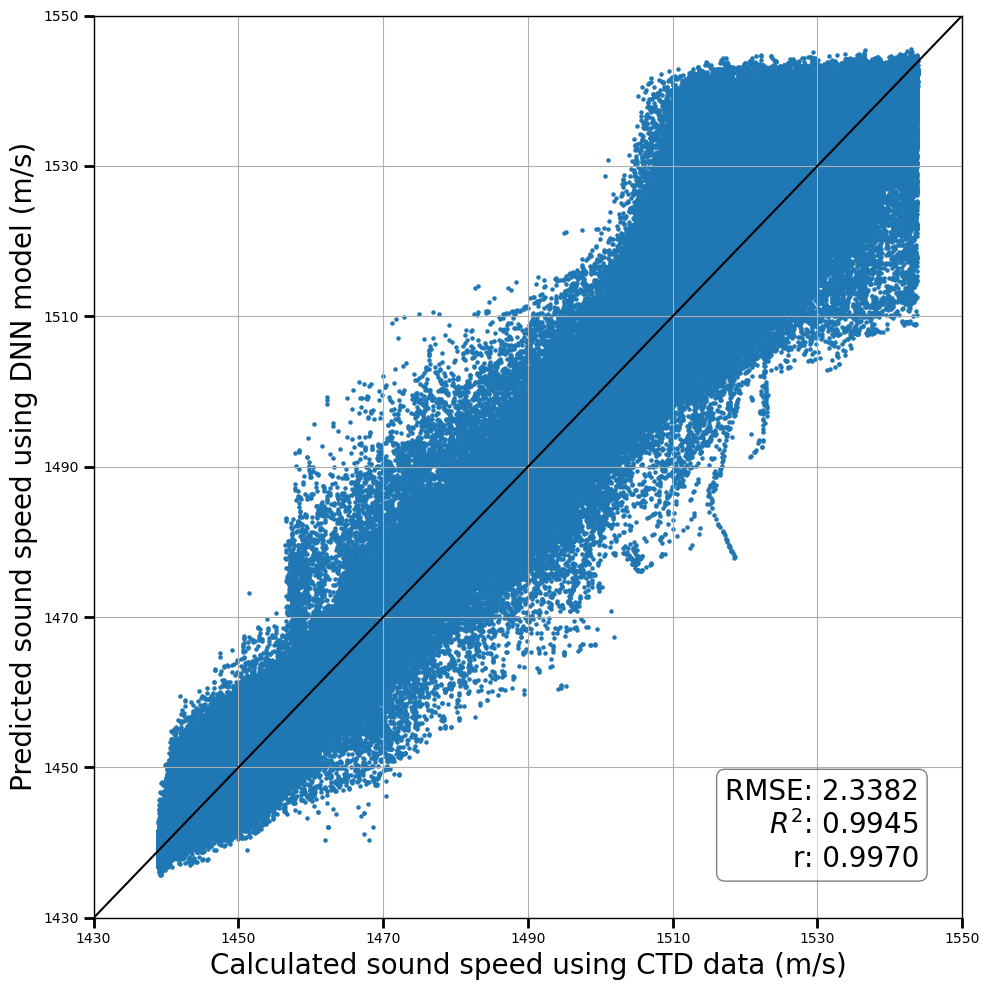

In [49]:
# Upper 400
rmse, r2, pearson_r, pearson_conf_interval, spearman_corr = calculate_metrics(df_upper['c'], df_upper['pred'])

# Printing the results
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")
print(f"Pearson Correlation: {pearson_r} with 95% CI: {pearson_conf_interval}")
print(f"Spearman's Correlation: {spearman_corr}")

plot_scatter(df_upper, 'c', 'pred', '../PaperPlot/upper_400_dnn.png')

In [30]:
df_lower = plot_df[plot_df['z']<=-400]

RMSE: 1.3125535373439632
R-squared: 0.9940167451762274
Pearson Correlation: 0.9970048813540757 with 95% CI: (0.9969563557224305, 0.997053406985721)
Spearman's Correlation: 0.9952637185921803


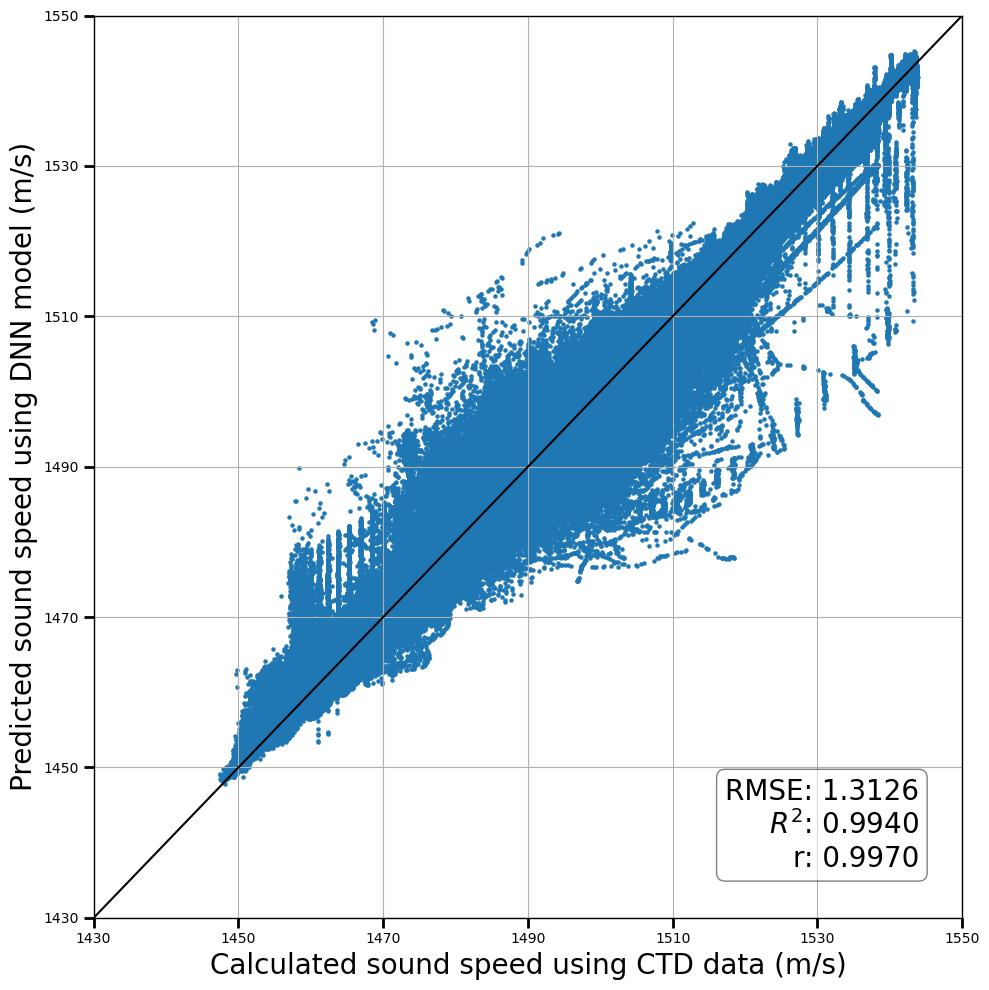

In [50]:
# Lower 
# To use the function, call it with your x and y data arrays:
rmse, r2, pearson_r, pearson_conf_interval, spearman_corr = calculate_metrics(df_lower['c'], df_lower['pred'])

# Printing the results
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")
print(f"Pearson Correlation: {pearson_r} with 95% CI: {pearson_conf_interval}")
print(f"Spearman's Correlation: {spearman_corr}")

plot_scatter(df_lower, 'c', 'pred', '../PaperPlot/lower_400_dnn.png')

In [33]:
df_top = plot_df[plot_df['z']>=-50]

RMSE: 1.5550439028117442
R-squared: 0.9980086554556066
Pearson Correlation: 0.9992166296803383 with 95% CI: (0.9991403485242029, 0.9992929108364738)
Spearman's Correlation: 0.9970188129097728


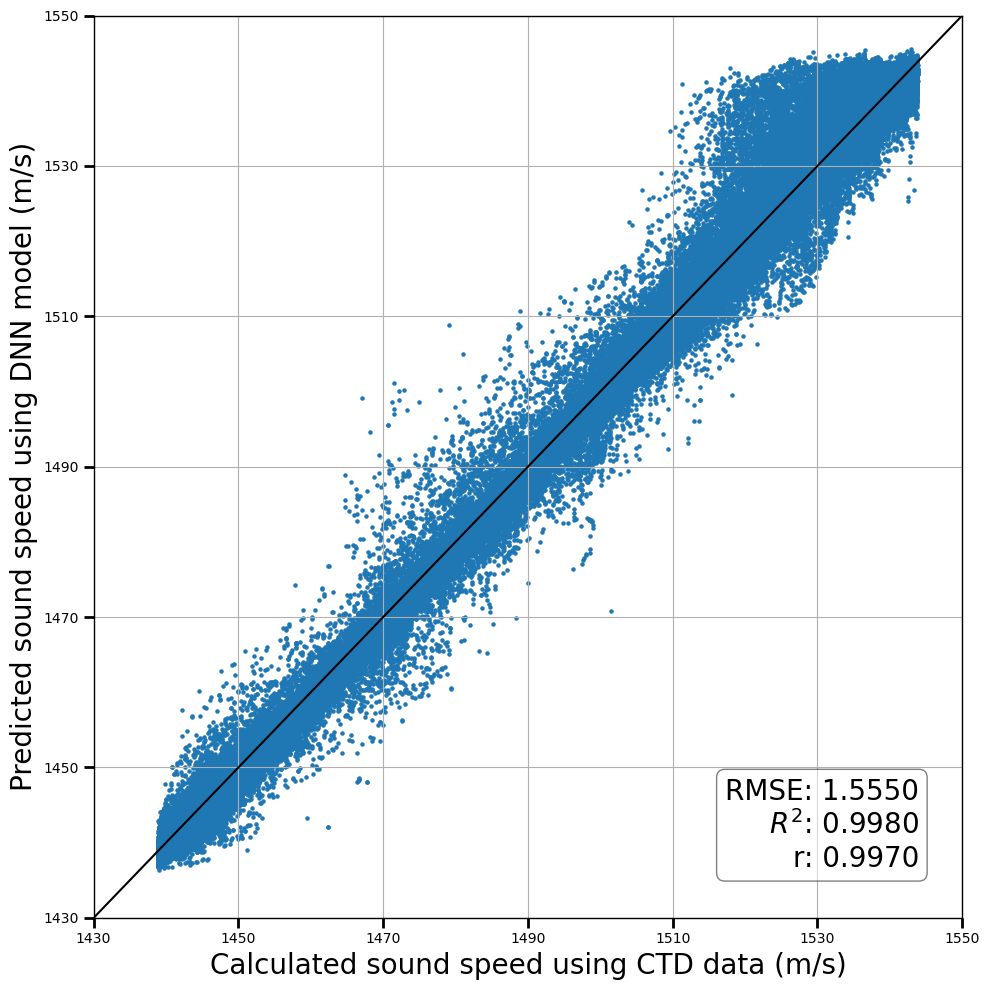

In [51]:
# top
# To use the function, call it with your x and y data arrays:
rmse, r2, pearson_r, pearson_conf_interval, spearman_corr = calculate_metrics(df_top['c'], df_top['pred'])

# Printing the results
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")
print(f"Pearson Correlation: {pearson_r} with 95% CI: {pearson_conf_interval}")
print(f"Spearman's Correlation: {spearman_corr}")

plot_scatter(df_top, 'c', 'pred', '../PaperPlot/top_50_dnn.png')

RMSE: 1.7295098703727423
R-squared: 0.9943004080567184
Pearson Correlation: 0.9971603658064245 with 95% CI: (0.9971219429260755, 0.9971987886867736)
Spearman's Correlation: 0.9967728041866062


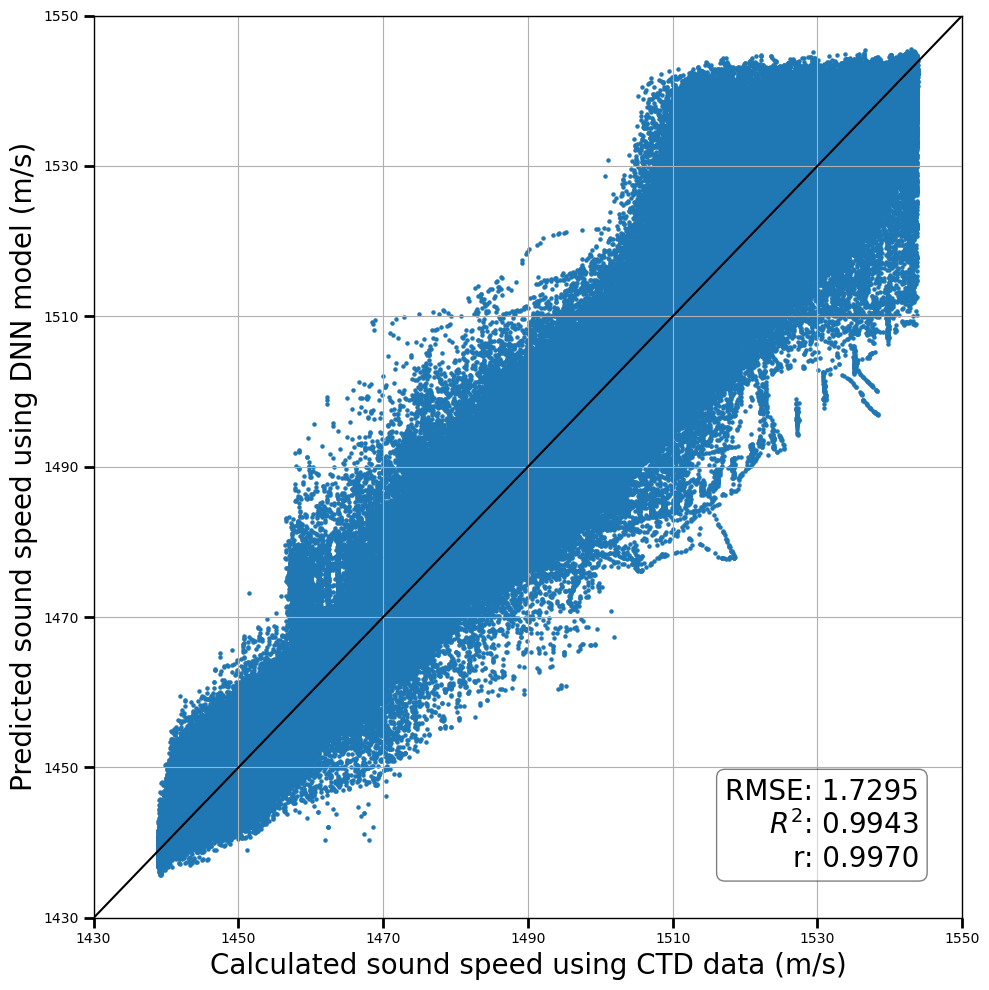

In [52]:
# all
# To use the function, call it with your x and y data arrays:
rmse, r2, pearson_r, pearson_conf_interval, spearman_corr = calculate_metrics(plot_df['c'], plot_df['pred'])

# Printing the results
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")
print(f"Pearson Correlation: {pearson_r} with 95% CI: {pearson_conf_interval}")
print(f"Spearman's Correlation: {spearman_corr}")

plot_scatter(plot_df, 'c', 'pred', '../PaperPlot/all_dnn.png')

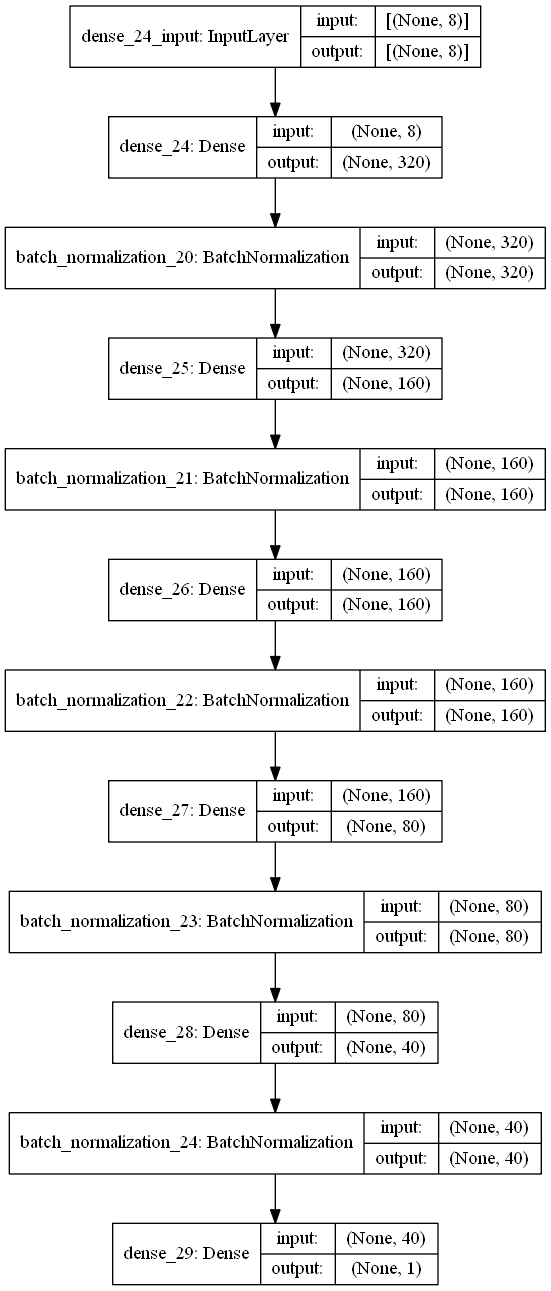

In [17]:
from tensorflow.keras.utils import plot_model

# Visualize the model of a specific fold, for example, the last one
plot_model(model, to_file='../PaperPlot/model_plot.png', show_shapes=True, show_layer_names=True)

In [6]:
from tensorflow.keras.models import load_model
import h5py
# Assuming 'model' is your trained model

# Save the model
model.save('../Models/dnn_combined_final.h5')  # Saves as an HDF5 file


In [ ]:
# from tensorflow.keras.models import load_model

# # Load the saved model
# loaded_model = load_model('../Models/dnn_final.h5')